### **Derivation of Surface Normals**

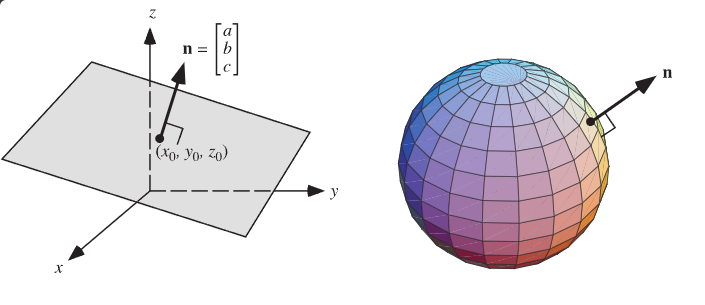


**Derivation of the Surface Normal**

We know that:
$$\text{Slope} = \frac{dy}{dx} \quad \text{(or } \frac{\text{Height}}{\text{Width}} \text{)}$$

A surface normal is the vector orthogonal to the tangent vectors along the x and y axes.

<br>

#### **1. Vector along the X-axis**
Consider the XZ plane where the surface has a slope of $p$.
If the x-displacement (width) is $dx$ and the height is $dz$, then the slope is $p$.

Solving for height:
$$\text{Slope} \times \text{Width} = \text{Height} \implies p \cdot dx$$

Assuming $dx = 1$, the height is $p$. Since we are not moving along the Y direction, the y-displacement is $0$.

Representing this as a vector:
$$\vec{V}_x = [1, 0, p]$$

<br>

#### **2. Vector along the Y-axis**
Similarly, for the vector along the YZ axis, if the slope is $q$ and we assume $dy = 1$, the vector becomes:

$$\vec{V}_y = [0, 1, q]$$

<br>

#### **3. Finding the Normal Vector**
The normal vector is orthogonal to both tangent vectors. Mathematically, this is found using the **cross product** of the vectors derived above:

$$\vec{N} = \vec{V}_x \times \vec{V}_y = \det \begin{bmatrix} \mathbf{i} & \mathbf{j} & \mathbf{k} \\ 1 & 0 & p \\ 0 & 1 & q \end{bmatrix}$$

Solving the determinant:

$$= \mathbf{i}(0 \cdot q - 1 \cdot p) - \mathbf{j}(1 \cdot q - 0 \cdot p) + \mathbf{k}(1 \cdot 1 - 0 \cdot 0)$$

$$= -p\mathbf{i} - q\mathbf{j} + 1\mathbf{k}$$

Representing this as a vector, we get:

$$\vec{N} = [-p, -q, 1]$$

### **Defining Knowns and Unknowns**

Here we consider the reflectance model to be **Lambertian**.

<br>

**1. The Knowns (Source Vector)**
The Source Vector $\vec{S}$ represents the lighting. It is defined by the position of the light source relative to the camera center along $(x, y, z)$.
* In practice, we calibrate the setup so we know exactly where the light is coming from for every image.

<br>

**2. The Unknowns (Surface Normal)**
The Normal vector is the orientation of the surface at a specific pixel.
$$\vec{N} = [n_x, n_y, n_z]$$

<br>

**3. Simplification**
For convenience, we often assume the **Albedo (Reflectance)** is constant or normalized to $1$.
$$\rho = 1$$

<br>

**The Simplified Equation**
With these assumptions, the equation becomes a simple dot product:

$$I = \vec{S} \cdot \vec{N}$$



<br>

**Inference:**
We can infer that if the **dot product similarity** between the Source vector and the Normal vector is high (i.e., they are facing each other), the intensity $I$ will be high (bright). If they are perpendicular, the intensity will be zero (dark).

### **Setup for Photometric Stereo**

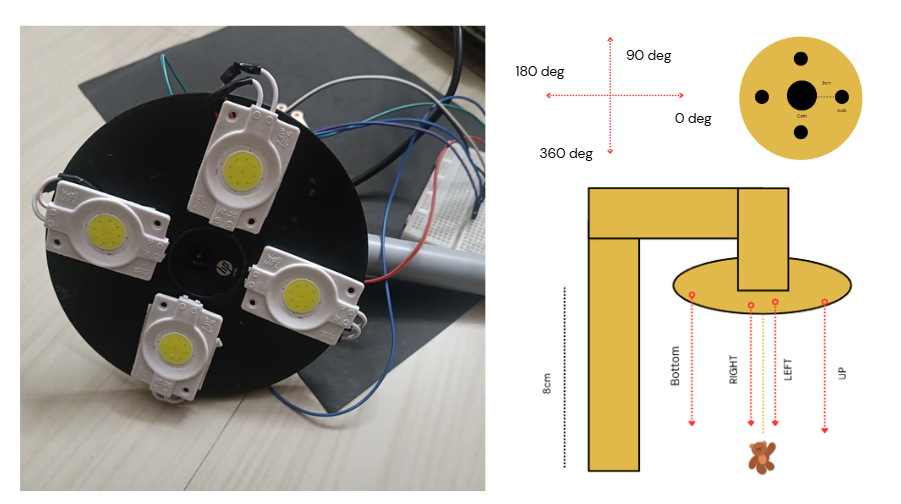

In [1]:
import numpy as np

# 1. DEFINE YOUR MEASURED DISTANCES
# Distance from center hole to the LED
xoffset = 3.5
# Height of the camera/lights above the object
zheight = 7.0

# 2. DEFINE RAW POSITIONS [X, Y, Z]
# Since it's a cross, one coordinate is always 0 for X/Y.
# Order matches your previous list: 0, 180, 270, 90 (Right, Left, Bottom, Top)
raw_light_positions = [
    [xoffset,  0,    zheight],  # Right (0 deg)
    [-xoffset, 0,    zheight],  # Left (180 deg)
    [0,  -xoffset,   zheight],  # Bottom (270 deg)
    [0,   xoffset,   zheight]   # Top (90 deg)
]

# 3. NORMALIZE TO GET UNIT VECTORS
LIGHTS = []
for pos in raw_light_positions:
    vec = np.array(pos)
    # Divide vector by its length (magnitude) to make it a unit vector
    unit_vec = vec / np.linalg.norm(vec)
    LIGHTS.append(np.round(unit_vec, 2))

LIGHTS = np.array(LIGHTS)

# Output
for i in range(len(LIGHTS)):
    print(f"L{i} Vector: {LIGHTS[i]}")

L0 Vector: [0.45 0.   0.89]
L1 Vector: [-0.45  0.    0.89]
L2 Vector: [ 0.   -0.45  0.89]
L3 Vector: [0.   0.45 0.89]


### **Solving for $\hat{N}$**

Let's start with the fundamental equation for the surface normal:
$$I = \hat{N} \cdot \vec{S}$$

Expanding the dot product into its components:
$$I = n_x s_x + n_y s_y + n_z s_z$$

<br>

**1. Identifying Variables**
* **Unknowns:** $n_x, n_y, n_z$ (The components of the Normal Vector).
* **Knowns:** $s_x, s_y, s_z$ (The Light Source Vector) and $I$ (The Pixel Intensity).

<br>

**2. The System of Equations**
Since we have **3 unknowns**, we need at least **3 unique equations** (images) to solve this system mathematically.

<br>

**3. The Solution Process**
We capture **3 images**, each with a different light source direction. This allows us to construct a system of linear equations (using matrices) and solve for the normal vector $\vec{N}$ at every pixel.

Loading images...
Computing Surface Normals...


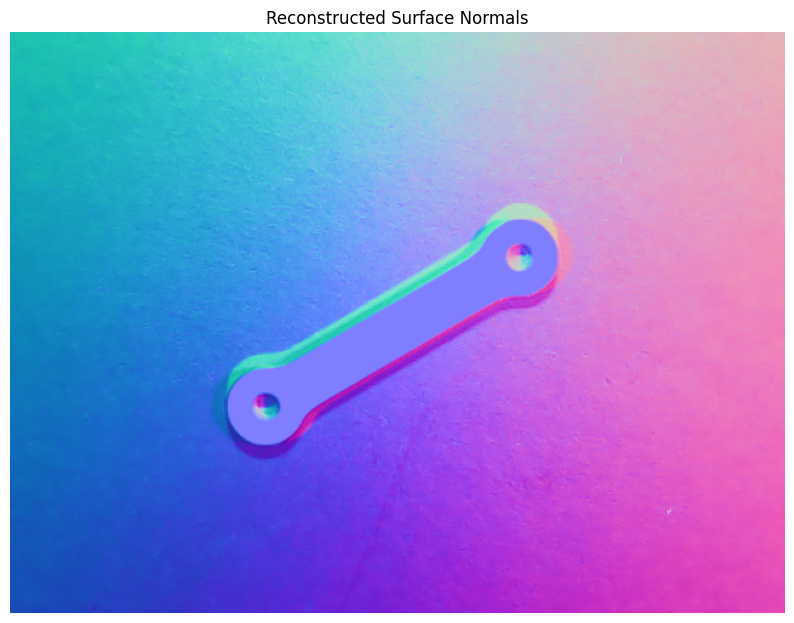

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def compute_normals(images, L):
    N_imgs, H, W = images.shape

    # Flatten images: (N, H, W) -> (N, Total_Pixels)
    I_flat = images.reshape(N_imgs, -1).astype(float)

    # Solve Linear System: G = pinv(L) . I
    L_inv = np.linalg.pinv(L)
    G = np.dot(L_inv, I_flat)

    # Normalize to get Unit Vectors (ignoring Albedo)
    magnitude = np.linalg.norm(G, axis=0)
    magnitude[magnitude == 0] = 1e-10 # Avoid divide by zero

    normals = G / magnitude

    # Reshape to (H, W, 3) and move channels to back
    normal_map = normals.reshape(3, H, W).transpose(1, 2, 0)

    return normal_map

# --- MAIN EXECUTION ---

# 1. LOAD SPECIFIC IMAGES
# Ensure this list matches the order of vectors in your 'LIGHTS' variable!
# (e.g., if LIGHTS[0] is Right, then filenames[0] must be 'right.jpg')
filenames = ["right.jpg", "left.jpg", "bottom.jpg", "top.jpg"]
loaded_imgs = []

print("Loading images...")
for f in filenames:
    # Load as Grayscale (0)
    img = cv2.imread(f, 0)

    if img is None:
        raise ValueError(f"Error: Could not find or load image '{f}'")

    loaded_imgs.append(img)

# Stack into (4, H, W) array
image_stack = np.array(loaded_imgs)

# 2. COMPUTE
# We assume 'LIGHTS' is already defined in your environment
print("Computing Surface Normals...")
normal_map = compute_normals(image_stack, LIGHTS)

# 3. VISUALIZE
# Scale [-1, 1] to [0, 255] for display
display_norm = ((normal_map + 1) / 2 * 255).astype(np.uint8)


#[nx,ny,nz] is gonna be as [r,g,b]
plt.figure(figsize=(10, 10))
plt.imshow(display_norm)
plt.title("Reconstructed Surface Normals")
plt.axis("off")
plt.show()

### **Integration of Surface Normals**

Once we have computed the surface normal $\hat{N} = [n_x, n_y, n_z]$ for every pixel, the next step is to reconstruct the 3D surface height $Z(x,y)$.

To do this, we must first convert the **Unit Normal components** into **Surface Gradients** ($p$ and $q$).

<br>

#### **1. Relating the Two Normal Representations**
We have two ways to represent the same surface orientation:

* **Calculated Unit Normal (from Photometric Stereo):**
    This vector has a length of 1.
    $$\hat{N} = [n_x, n_y, n_z]$$

* **Gradient-Based Normal (from Calculus derivation):**
    This vector is defined by the surface slopes $p = \frac{\partial z}{\partial x}$ and $q = \frac{\partial z}{\partial y}$.
    $$\vec{N}_{grad} = [-p, -q, 1]$$

<br>

#### **2. Deriving P and Q**
Since both vectors represent the same surface orientation, they must be parallel. Therefore, they differ only by a scaling factor $k$.

We can scale the Unit Normal $\hat{N}$ such that its Z-component becomes 1. This is done by dividing the vector by $n_z$:

$$\frac{\hat{N}}{n_z} = \left[ \frac{n_x}{n_z}, \frac{n_y}{n_z}, \frac{n_z}{n_z} \right] = \left[ \frac{n_x}{n_z}, \frac{n_y}{n_z}, 1 \right]$$

Now, we equate this scaled vector to the Gradient Normal $[-p, -q, 1]$:

$$\left[ \frac{n_x}{n_z}, \frac{n_y}{n_z}, 1 \right] = [-p, -q, 1]$$

By comparing the corresponding $x$ and $y$ components, we derive the formulas for the gradients:

$$p = -\frac{n_x}{n_z} \quad \text{and} \quad q = -\frac{n_y}{n_z}$$


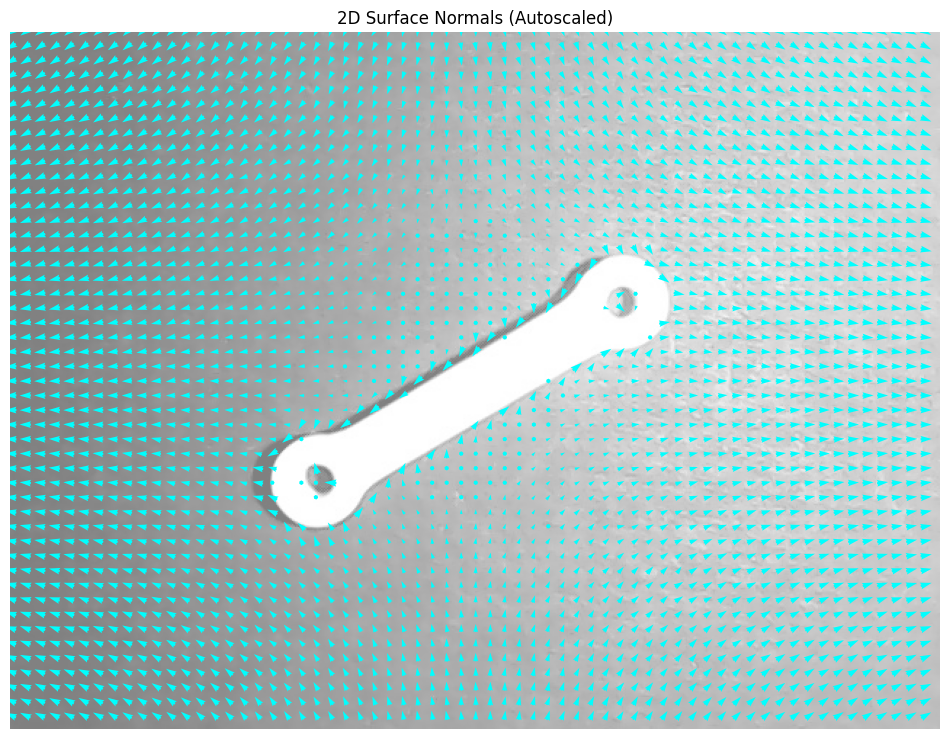

In [4]:
import matplotlib.pyplot as plt
import numpy as np


step = 10
arrow_color = 'cyan'

# --- PREPARE DATA ---
H, W, _ = normal_map.shape

# 1. Create Grid
Y, X = np.mgrid[0:H:step, 0:W:step]

# 2. Extract Components
# We flip V because image Y-axis goes DOWN, but math Y-axis goes UP
U = normal_map[::step, ::step, 0]
V = -normal_map[::step, ::step, 1]

# 3. Mask Background (Optional)
# If the vector is super short (background), set it to NaN so it doesn't plot
magnitude = np.sqrt(U**2 + V**2)
mask = magnitude < 0.1  # Ignore flat/background areas
U[mask] = np.nan
V[mask] = np.nan

# --- PLOTTING ---
plt.figure(figsize=(12, 12))

# Show base image
plt.imshow(loaded_imgs[0], cmap='gray', alpha=0.5)

# Draw Quiver
# pivot='mid': The dot is the center of the arrow
# scale=None: Matplotlib tries to auto-size them
# width=0.005: Makes the arrow shaft thicker
plt.quiver(X, Y, U, V, color=arrow_color, pivot='mid', scale=None, width=0.005)

plt.title(f"2D Surface Normals (Autoscaled)")
plt.axis("off")
plt.show()

### **Surface Integration: Reconstructing Height from Gradients**


Having computed the surface gradients $P$ (slope in $x$) and $Q$ (slope in $y$), we can now reconstruct the 3D surface height $Z$.

Since the gradient represents the **rate of change** of height, the height itself is simply the **accumulation** (integral) of these changes over the image.

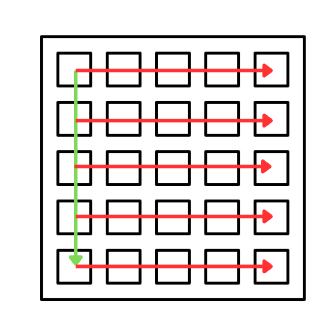

<br>

#### **1. The Integration Strategy (Path Dependence)**
To solve for $Z(x,y)$, we use a **Cumulative Sum** approach. Since integration requires a specific path, we adopt a standard **"Column-First, then Row"** strategy (often called the "L-Shape" method):

1.  **The Vertical "Spine" (Column 0):**
    First, we calculate the height of the very first column by summing the vertical slopes ($Q$) from top to bottom.
    $$Z(0, y) = \sum_{i=0}^{y} Q(0, i)$$
    *This establishes the relative height of the left edge of the image.*

2.  **The Horizontal "Ribs" (Rows):**
    Next, for every row $y$, we calculate the rest of the pixels by summing the horizontal slopes ($P$) from left to right, using the "Spine" value as the starting point.
    $$Z(x, y) = Z(0, y) + \sum_{j=0}^{x} P(j, y)$$

<br>

#### **2. The Challenge: Error Propagation**
While this method is mathematically valid and intuitive for learning, it introduces a specific artifact known as **"Streaking."**

* **The Cause:** If a pixel at the start of a row (e.g., on the "Spine") contains noise or a shadow, that error is added to **every subsequent pixel** in that row during the cumulative sum.
* **The Visual Effect:** Small errors effectively shift entire rows up or down, creating visible horizontal lines across the 3D model.

<br>

#### **3. Advanced Alternatives**
To mitigate this, advanced applications use **Global Integration** methods:
* **Poisson Integration:** Solves for all pixels simultaneously by minimizing the global error.
* **Frankot-Chellappa:** Enforces integrability in the Fourier domain.

However, for the purpose of understanding the physical relationship between Normals and Depth, the **Naive Cumulative Sum** provides the clearest direct visualization of the process.

Processing ROI (Standard Integration, Cropping 145px)...
Rendering ROI Surface...


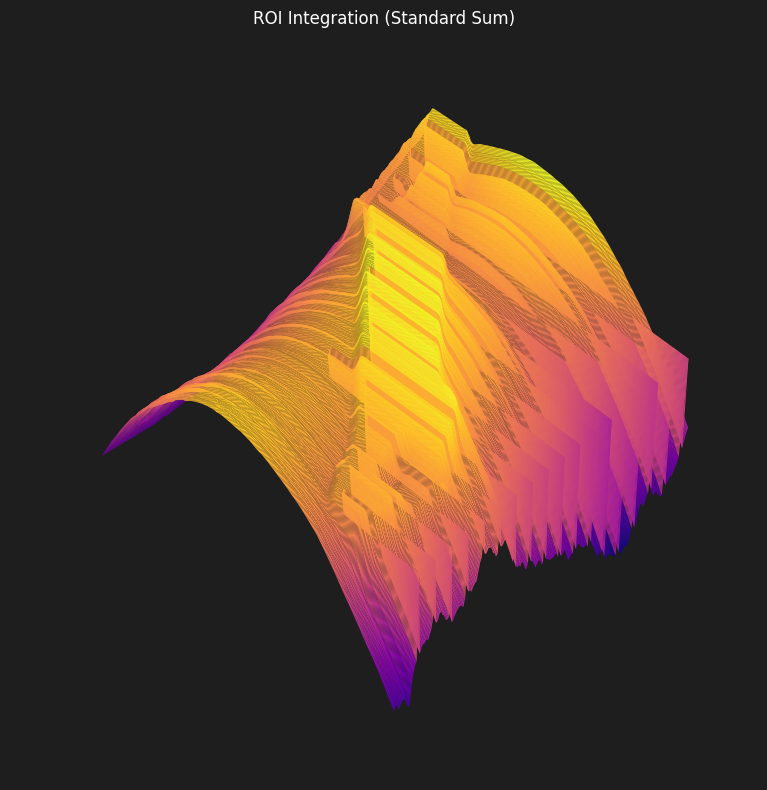

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ==========================================
# 1. INTEGRATION FUNCTIONS
# ==========================================

def integrate_standard_roi(grad_x, grad_y):
    """
    Standard Sum Integration (Col 0 -> Rows)
    """
    H, W = grad_x.shape
    Z = np.zeros((H, W))

    # 1. Vertical Spine (Column 0)
    # Integrate grad_y down the first column
    Z[:, 0] = np.cumsum(grad_y[:, 0], axis=0)

    # 2. Horizontal Ribs (Rows)
    # Integrate grad_x across all rows
    row_cum_sum = np.cumsum(grad_x, axis=1)

    # 3. Align Rows to Spine
    # Current cumsum starts at arbitrary values. We shift them so
    # the first column matches the "Spine" we calculated in Step 1.

    # Get the value of the first column of the X-integration
    x_start_vals = row_cum_sum[:, 0:1]

    # Formula: Spine_Height + (Row_Sum - Row_Start_Value)
    Z = Z[:, 0:1] + row_cum_sum - x_start_vals

    return Z

def detrend_surface(Z):
    """ Fits a plane and subtracts it to remove global tilt. """
    H, W = Z.shape
    Y, X = np.indices((H, W))

    # Ignore NaNs during fitting if any exist
    mask = np.isfinite(Z)
    if not mask.any(): return Z

    A = np.c_[X[mask], Y[mask], np.ones(mask.sum())]
    C, _, _, _ = np.linalg.lstsq(A, Z[mask], rcond=None)

    plane = C[0] * X + C[1] * Y + C[2]
    return Z - plane

# ==========================================
# 2. MAIN EXECUTION (ROI ONLY)
# ==========================================

# CONFIG: Pixels to remove from edges
CROP = 145

if 'normal_map' in locals():
    print(f"Processing ROI (Standard Integration, Cropping {CROP}px)...")

    # A. CROP NORMAL MAP
    nm_roi = normal_map[CROP:-CROP, CROP:-CROP]

    # B. COMPUTE GRADIENTS
    nx = nm_roi[:, :, 0]
    ny = nm_roi[:, :, 1]
    nz = nm_roi[:, :, 2]

    # Safe Division (Prevent divide by zero)
    nz_safe = np.where(np.abs(nz) < 0.1, 0.1, nz)

    grad_x = -nx / nz_safe
    grad_y = -ny / nz_safe

    # Optional: Mask out gradients if they are too steep (noise)
    grad_x[np.abs(grad_x) > 5] = 0
    grad_y[np.abs(grad_y) > 5] = 0

    # C. INTEGRATE
    Z_roi = integrate_standard_roi(grad_x, grad_y)

    # D. DETREND & CLEANUP
    Z_final = detrend_surface(Z_roi)

    # Sanitize for plotting (fill NaNs with 0)
    Z_final = np.nan_to_num(Z_final, nan=0.0)
    Z_final = Z_final - np.min(Z_final) # Shift to 0

    # ==========================================
    # 3. VISUALIZATION
    # ==========================================
    print("Rendering ROI Surface...")
    fig = plt.figure(figsize=(10, 8))
    fig.patch.set_facecolor('#1e1e1e')

    ax = fig.add_subplot(111, projection='3d')
    ax.set_facecolor('#1e1e1e')

    H_crop, W_crop = Z_final.shape
    X, Y = np.meshgrid(np.arange(W_crop), np.arange(H_crop))

    # Plot
    surf = ax.plot_surface(X, Y, Z_final, cmap='plasma',
                           edgecolor='none', rstride=1, cstride=1)

    ax.view_init(elev=50, azim=-45)
    ax.set_title(f"ROI Integration (Standard Sum)", color='white')
    ax.axis('off')

    plt.tight_layout()
    plt.show()

else:
    print("Error: 'normal_map' not found. Please run the Normal Calculation step first.")

### **Note: Region of Interest (ROI) Integration**
In the code below, the integration process is restricted specifically to a **Region of Interest (ROI)** rather than the entire image.

**Why is this done?**
Standard integration methods ( like the cumulative sum used here ) are highly sensitive to noise. If the integration starts at the image edge where data is often noisy or contains shadows that initial error will propagate across the entire surface, causing significant distortion ( streaking ). By cropping to an ROI, we ensure the integration begins on valid surface data, resulting in a much more accurate 3D reconstruction.



### **Assumptions of this Method**
* **Lambertian Surface:** The object is matte (diffuse reflection only, no shiny specular highlights).
* **Distant Lighting:** Light rays are assumed to be parallel (uniform direction).
* **Stationary Camera:** The object and camera do not move; only the light source changes position.



### **References**
* **Linear Algebra Visualization:** [3Blue1Brown Series](https://www.youtube.com/playlist?list=PLZHQObOWTQDPD3MizzM2xVFitgF8hE_ab)
* **Photometric Stereo Lectures:** [Computer Vision Course](https://www.youtube.com/playlist?list=PL2zRqk16wsdpyQNZ6WFlGQtDICpzzQ925)